In [2]:
# Import the libraries we need
import pandas as pd
import numpy as np

import re
import random

import requests
from requests import get
from bs4 import BeautifulSoup
from requests.compat import urljoin
#for creating a user based URL, 'urljoin' is used

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.chrome.options import Options

import datetime
from datetime import timezone, time

import matplotlib as plt
import matplotlib.pyplot as plt  # To visualize
from matplotlib.colors import LinearSegmentedColormap
# Import seaborn
import seaborn as sns

import json
from pandas.io.json import json_normalize







In [3]:
# Get current date from the datetime library and convert it to aware format using tz_localize('Asia/Kolkata')
today = pd.to_datetime('today').tz_localize('Asia/Kolkata')
today = today.replace(hour=0, minute=0, second=0, microsecond=0)
print(today)

base_url = "https://understat.com/league/"

#Ask use to enter the title ID from selected range
league_id = input("1. English Premier League - 1\n2.La Liga - 2\n3.Bundesliga - 3\n4.Serie_A - 4\n5. Ligue_1 - 5\nEnter the League ID:")


league_id = int(league_id)

if (league_id == 1):
    league_url = "EPL"
    league_country = "England"
elif (league_id == 2):
    league_url = "La_liga"
    league_country = "Spain"
elif (league_id == 3):
    league_url = "Bundesliga"
    league_country = "Germany"
elif (league_id == 4):
    league_url = "Serie_A"
    league_country = "Italy"
elif (league_id == 5):
    league_url = "Ligue_1"
    league_country = "France"
else:
    raise TypeError("Kindly select from 1 to 5")
    

         
        
#Combine base URL and League_URL to get the final URL that has to be opened
xg_url = urljoin(base_url,league_url)


print(xg_url)


2021-01-03 00:00:00+05:30


1. English Premier League - 1
2.La Liga - 2
3.Bundesliga - 3
4.Serie_A - 4
5. Ligue_1 - 5
Enter the League ID: 2


https://understat.com/league/La_liga


In [4]:

# Understat use data inside a JSON.parse() function via the below coode to get data of players in a panda dataframe:
#-------------------------------------------------------------------------------------------------------------------        
response = requests.get(xg_url) #to read the html
teamsData = re.search("teamsData\s+=\s+JSON.parse\('([^']+)", response.text) #to read dates data
decoded_string = bytes(teamsData.groups()[0], 'utf-8').decode('unicode_escape') #decoding the string
teamObj = json.loads(decoded_string) #json.loads() for decoding. It takes in a string and returns a JSON object
#print(teamObj['71'])
teamsDataDF = pd.json_normalize(teamObj) #json_normalize() is used for flatting the object into a pandas dataframe

#---------------------------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------------------------
headers = list(teamsDataDF) 

team_id =[]
for header in headers: 
    team_id.append(header)

temp = [int(sub.split('.')[0]) for sub in team_id]
team_id = pd.unique(temp)
team_id_str = team_id.astype(str) #conver it to string as somehow teamObj takes requires the ID to be in a string
#print(team_id)
#-------------------------------------------------------------------------------------------------------------------       

#---------faltten nested JSON-------------------------------------------------------------------------
teams_match_data = pd.DataFrame()
i=0
for id in team_id:
    xyz = teamObj[team_id_str[i]]
    team_match_data = pd.json_normalize(data=xyz, meta=['id', 'title'], record_path='history')
    teams_match_data = teams_match_data.append(team_match_data,ignore_index = True)
    i=i+1

teams_match_data
#--------------------------------------------------------------------------------------------------------
# teams_match_data is a database of every game played. We will use this at the core database to generate xG, xGA, via pivot table so that we can go back to any previous matchdate we want in the future
#---------------------------------------------------------------------------------------------------------------------
teams_match_data = teams_match_data.drop(['deep', 'deep_allowed', 'ppda.att', 'ppda.def', 'ppda_allowed.att', 'ppda_allowed.def'],axis=1)
teams_match_data = teams_match_data.rename( columns = {'h_a':'home_away','scored':'G','missed':'GA','pts':'points','title':'team','id':'team_id'})
#print(list(teams_match_data))
#print(teams_match_data.dtypes)
teams_match_data['date'] = pd.to_datetime(teams_match_data['date']) #this datetime is according to UK timing
teams_match_data['date'] = teams_match_data['date'].dt.tz_localize('GMT') #First localize to GMT
teams_match_data['date'] = teams_match_data['date'].dt.tz_convert('Asia/Kolkata') #Then convert to Asia/Kolkata for India timings
teams_match_data['home_away'] = teams_match_data['home_away'].replace({'h':'home','a':'away'}) 
teams_match_data['result'] = teams_match_data['result'].replace({'w':'win','l':'lose','d':'draw'})
teams_match_data['games'] = teams_match_data['wins'] + teams_match_data['draws'] + teams_match_data['loses'] 
teams_match_data = teams_match_data[['team_id', 'team', 'date', 'home_away', 'result', 'G', 'GA', 'xG', 'xGA', 'npxG', 'npxGA', 'npxGD', 'wins', 'draws', 'loses', 'points', 'xpts','games']]
teams_match_data
teams_match_data.to_csv("C:/Python Advanced/python-for-fantasy-football-master/python-for-fantasy-football-master/4 - APIs and JSON Data/Football Leagues Fixtures/%s/%s_team_match_data "%(league_url,league_country) + today.strftime("%d_%m_%Y") + ".csv", index=False)

#---------------------------------------------------------------------------------------------------------------------
# teams_data_summary is the summary table as shown in Undetstat. 
#Pivot table automatically averages the data, but we want the sum to reflect here

teams_data_summary = pd.pivot_table(data = teams_match_data, index = ['team'], values = ['G', 'GA', 'xG', 'xGA', 'npxG', 'npxGA', 'games','points','wins', 'draws', 'loses'],aggfunc = [np.sum])

#Now we will convert the pivot table back to dataframe. For that we have to drop the empty column and then reset the index
#Use 'rename_axis(None, axis=1)' with reset_index() to remove any categories you might have created while using pivot table

teams_data_summary.columns = teams_data_summary.columns.droplevel(0)
teams_data_summary = teams_data_summary.reset_index().rename_axis(None, axis=1) 

#Adding 'GD' and 'xGD'. 'GD' to make it easier to sort according to league table standing rules
teams_data_summary['GD'] = teams_data_summary['G'] - teams_data_summary['GA']
teams_data_summary['xGD'] = teams_data_summary['xG'] - teams_data_summary['xGA']
teams_data_summary['GD_vs_xGD'] = teams_data_summary['GD'] - teams_data_summary['xGD']
teams_data_summary['npxGD'] = teams_data_summary['npxG'] - teams_data_summary['npxGA']

#League Table Rule
# 1. EPL : If any clubs finish with the same number of points, their position in the Premier League table is determined by: 1.Goal difference, 2. Higher number of goals scored. If the teams still cannot be separated, they will be awarded the same position in the table.
# 2. La_Liga: if points are equal between two or more clubs, then the tie is broken through: 1.Head-to-head points between tied teams, 2. Head-to-head goal difference between tied teams, 3. Goal difference
# 3. Bundesliga: if points are equal between two or more clubs, then the tie is broken through: 1.Goal difference, 2. Goals scored for the entire season, 3. Head-to-head results (total points accumulated)
# 4. Serie A: if points are equal between two or more clubs, then the tie is broken through: 1. Head-to-head points, 2.Head-to-head goal difference, 3. Goal difference, 4. Higher number of goals scored
# 5. Ligue 1: if points are equal between two or more clubs, then the tie is broken through: 1.Goal difference, 2. Higher number of goals scored

#EPL, Bundesliga and Ligue 1 are sorted properly. Need to work on La Liga and Serie A (Head to Head)
# For La liga and Serie A, if points are level, then we have to access teams_match_data to find the fixture between the two teams with level points and compare their points against eachother. If points are same then we look at their Goal Difference in the two matches. If there is no clear winner then we compare the overall Goal Differene

#Rearranging the columns according to requirement and sorting for table standing
teams_data_summary = teams_data_summary[['team','games','wins', 'draws', 'loses','points','G', 'GA','GD', 'xG', 'xGA','xGD','GD_vs_xGD', 'npxG', 'npxGA', 'npxGD']]

if (league_id == 1):
    teams_data_summary = teams_data_summary.sort_values(by=['points','GD','G'], ascending=[False,False,False])
elif (league_id == 2):
    teams_data_summary = teams_data_summary.sort_values(by=['points','GD','G'], ascending=[False,False,False])
elif (league_id == 3):
    teams_data_summary = teams_data_summary.sort_values(by=['points','GD','G'], ascending=[False,False,False])
elif (league_id == 4):
    teams_data_summary = teams_data_summary.sort_values(by=['points','GD','G'], ascending=[False,False,False])
elif (league_id == 5):
    teams_data_summary = teams_data_summary.sort_values(by=['points','GD','G'], ascending=[False,False,False])
else:
    raise TypeError("Kindly select from 1 to 5")


teams_data_summary = teams_data_summary.reset_index() #resetting the index to show ranking
teams_data_summary = teams_data_summary.drop(['index'],axis=1) #dropping the index column formed after reseting the index
teams_data_summary.to_csv("C:/Python Advanced/python-for-fantasy-football-master/python-for-fantasy-football-master/4 - APIs and JSON Data/Football Leagues Fixtures/%s/%s_teams_data_summary "%(league_url,league_country) + today.strftime("%d_%m_%Y") + ".csv", index=False)
teams_data_summary

#-------------------------------------------------------------------------------------------------------------------------------------------

,team,games,wins,draws,loses,points,G,GA,GD,xG,xGA,xGD,GD_vs_xGD,npxG,npxGA,npxGD
0,Real Madrid,17,11,3,3,36,30,15,15,31.245038,18.892896,12.352142,2.647858,29.758478,14.433356,15.325122
1,Atletico Madrid,14,11,2,1,35,27,5,22,21.995865,11.141837,10.854028,11.145972,18.869745,11.141837,7.727908
2,Real Sociedad,17,8,5,4,29,26,12,14,29.133160,15.631941,13.501219,0.498781,23.922968,13.402746,10.520222
3,Villarreal,17,7,8,2,29,22,17,5,25.286030,16.859818,8.426212,-3.426212,21.569774,13.886841,7.682933
4,Sevilla,15,8,3,4,27,18,11,7,21.036113,13.786164,7.249949,-0.249949,18.806275,12.269723,6.536552
5,Barcelona,15,7,4,4,25,29,15,14,34.923929,19.820896,15.103033,-1.103033,31.207549,18.334465,12.873084
6,Granada,15,7,3,5,24,19,23,-4,18.724148,25.204505,-6.480357,2.480357,16.494700,22.814295,-6.319595
7,Celta Vigo,17,6,5,6,23,22,24,-2,27.375661,19.016322,8.359339,-10.359339,25.146081,16.786493,8.359588
8,Real Betis,17,6,2,9,20,20,31,-11,20.065133,25.526220,-5.461087,-5.538913,16.319132,20.323389,-4.004257
9,Cadiz,16,5,4,7,19,11,20,-9,13.568242,16.380192,-2.811950,-6.188050,13.568242,15.637040,-2.068798


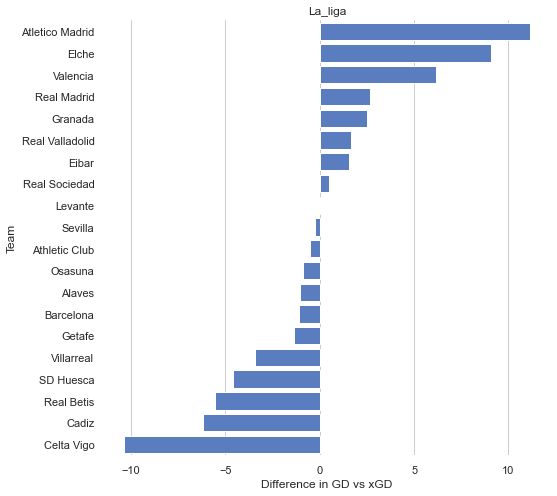

In [5]:
# Under performing vs Over Performing teams
#-------------------------------------------------------------------------------------------------------------------------------------------
teams_data_summary =teams_data_summary.sort_values(by=['GD_vs_xGD'], ascending=False)


 
# Set the plot style and colour palette to use (remember dodgy spelling if you're from the UK!)
sns.set(style='whitegrid')
sns.set_color_codes('muted')
 
# Initialize the matplotlib figure (f) and axes (ax), and set width and height of the plot
f, ax = plt.subplots(figsize=(8, 8))
 
# Create the plot, choosing the variables for each axis, the data source and the colour (b = blue)
sns.barplot(x='GD_vs_xGD', y='team', data=teams_data_summary, color='b')
 
# Rename the axes, setting y axis label to be blank
ax.set(ylabel='Team', xlabel='Difference in GD vs xGD')
plt.title(league_url) 
# Remove the borders from the plot
sns.despine(left=True, bottom=True)

plt.savefig('C:/Python Advanced/python-for-fantasy-football-master/python-for-fantasy-football-master/4 - APIs and JSON Data/Football Leagues Fixtures/%s/%s_xg_week '%(league_url,league_country) + today.strftime("%d_%m_%Y") + '.jpeg', bbox_inches='tight')
teams_data_summary.to_csv('C:/Python Advanced/python-for-fantasy-football-master/python-for-fantasy-football-master/4 - APIs and JSON Data/Football Leagues Fixtures/%s/%s_xg_week '%(league_url,league_country) + today.strftime("%d_%m_%Y") + '.csv')

#-------------------------------------------------------------------------------------------------------------------------------------------

In [8]:

#-------------------------------------------------------------------------------------------------------------------------------------------


# Understat use data inside a JSON.parse() function via the below coode to get data of fixtures in a panda dataframe:
        
response = requests.get(xg_url) #to read the html


datesData = re.search("datesData\s+=\s+JSON.parse\('([^']+)", response.text) #to read dates data
decoded_string = bytes(datesData.groups()[0], 'utf-8').decode('unicode_escape') #decoding the string
dateObj = json.loads(decoded_string) #json.loads() for decoding. It takes in a string and returns a JSON object
datesDataDF = pd.json_normalize(dateObj) #json_normalize() is used for flatting the object into a pandas dataframe
datesDataDF

#Dropping irrelevent columns ['id','h.id','h.short_title','a.id','a.short_title']
datesDataDF = datesDataDF.drop(['id','h.id','h.short_title','a.id','a.short_title'], axis=1)
#datesData_headers = {'isResult','datetime','h.title','a.title','goals.h','goals.a','xG.h', 'xG.a'}

#Now removing all 'None' and replacing it with Nan
# You can use DataFrame.fillna or Series.fillna which will replace the Python object None, not the string 'None'.
datesDataDF = datesDataDF.fillna(value=np.nan)

#datesDataDF['isResult'] = datesDataDF['isResult'].astype(str)
datesDataDF['h.title'] = datesDataDF['h.title'].astype(str)
datesDataDF['a.title'] = datesDataDF['a.title'].astype(str)
datesDataDF['goals.h'] = datesDataDF['goals.h'].astype(float).astype('Int32')
datesDataDF['goals.a'] = datesDataDF['goals.a'].astype(float).astype('Int32')
datesDataDF['xG.h'] = datesDataDF['xG.h'].astype(float)
datesDataDF['xG.a'] = datesDataDF['xG.a'].astype(float)
datesDataDF['datetime'] = pd.to_datetime(datesDataDF['datetime']) #this datetime is according to UK timing
datesDataDF['datetime'] = datesDataDF['datetime'].dt.tz_localize('GMT') #First localize to GMT
datesDataDF['datetime'] = datesDataDF['datetime'].dt.tz_convert('Asia/Kolkata') #Then convert to Asia/Kolkata for India timings

print(datesDataDF.dtypes)




one_week = today + datetime.timedelta(days=6)
previous_week = today - datetime.timedelta(days=7)
# https://stackoverflow.com/questions/29370057/select-dataframe-rows-between-two-dates

start_date = today
end_date = one_week
last_date = previous_week
#greater than the start date and smaller than the end date
#mask = (df['date'] > start_date) & (df['date'] <= end_date)

last_weekend_fixture = datesDataDF[(datesDataDF['datetime'] >= last_date) & (datesDataDF['datetime'] < start_date)]
last_weekend_fixture = last_weekend_fixture.drop(['isResult','xG.h','xG.a','forecast.w','forecast.d','forecast.l'],axis=1)
last_weekend_fixture = last_weekend_fixture.rename( columns = {'h.title':'Home_Team','a.title':'Away_Team','goals.h':'Home_Team_Goals','goals.a':'Away_Team_Goals'})
last_weekend_fixture.to_csv("C:/Python Advanced/python-for-fantasy-football-master/python-for-fantasy-football-master/4 - APIs and JSON Data/Football Leagues Fixtures/%s/%s_last_weekend_fixture "%(league_url,league_country) + last_date.strftime("%d_%m_%Y") +".csv",index=False)



future_fixtures = datesDataDF[datesDataDF['datetime'] >= start_date]
this_weekend_fixture = datesDataDF[(datesDataDF['datetime'] >= start_date) & (datesDataDF['datetime'] < end_date)]  
this_weekend_fixture = this_weekend_fixture.drop(['isResult','xG.h','xG.a','forecast.w','forecast.d','forecast.l'],axis=1)
this_weekend_fixture = this_weekend_fixture.rename( columns = {'h.title':'Home_Team','a.title':'Away_Team','goals.h':'Home_Team_Goals','goals.a':'Away_Team_Goals'})
this_weekend_fixture.to_csv("C:/Python Advanced/python-for-fantasy-football-master/python-for-fantasy-football-master/4 - APIs and JSON Data/Football Leagues Fixtures/%s/%s_weekend_fixture "%(league_url,league_country) + today.strftime("%d_%m_%Y") +".csv",index=False)
this_weekend_fixture

#-------------------------------------------------------------------------------------------------------------------------------------------

isResult                              bool
datetime      datetime64[ns, Asia/Kolkata]
h.title                             object
a.title                             object
goals.h                              Int32
goals.a                              Int32
xG.h                               float64
xG.a                               float64
forecast.w                          object
forecast.d                          object
forecast.l                          object
dtype: object


,datetime,Home_Team,Away_Team,Home_Team_Goals,Away_Team_Goals
162,2021-01-03 01:30:00+05:30,Real Madrid,Celta Vigo,2,0
163,2021-01-03 18:30:00+05:30,Athletic Club,Elche,<NA>,<NA>
164,2021-01-03 20:45:00+05:30,Alaves,Atletico Madrid,<NA>,<NA>
165,2021-01-03 23:00:00+05:30,Eibar,Granada,<NA>,<NA>
166,2021-01-03 23:00:00+05:30,Real Sociedad,Osasuna,<NA>,<NA>
167,2021-01-04 01:30:00+05:30,SD Huesca,Barcelona,<NA>,<NA>
168,2021-01-05 01:30:00+05:30,Valencia,Cadiz,<NA>,<NA>
169,2021-01-07 01:30:00+05:30,Athletic Club,Barcelona,<NA>,<NA>


In [9]:

#-------------------------------------------------------------------------------------------------------------------------------------------

# To enable us to carry out further analysis, it would be great to have per game versions of each stat as well as the totals. 
# We could do this one by one like we did with the goal difference columns, but there is a better way

# Print a list of the columns in the dataframe
print("1\n",list(teams_data_summary))

# Create a list of the columns we want
# We could have done this programmatically by removing the unwanted columns from the list above, but in this case it's just as easy to copy and paste!
cols = ['G', 'GA', 'GD', 'xG', 'xGA', 'xGD', 'npxG', 'npxGA', 'npxGD']
 
# Create new columns for per game versions of each stat in the cols list
# This code iterates through the list and adds new columns for each item in the list, using string formatting to create the column names
# i.e. for each column in the cols list, create a new column where col name = original col name + '_pg' and col value = original column value / games

for col in cols:
    teams_data_summary["%s_pg"%col] = teams_data_summary[col]/teams_data_summary["games"] # %d -> number, %s -> string
#print ("2\n",teams_data_summary.head())

# Now we can get onto the main subject of this article, which is how to project stats for upcoming fixtures. 
# In this case we will try to predict the average goals we can expect for each team in week 9 of the EPL season using xG_pg and xGA_pg.
#  First, we need to get the upcoming fixtures (from above 'this_weekend_fixture')

#Load the match fixtures
this_weekend_fixture


# A quick method that you can use to adjust stats for matchups. The first step is to add xG_pg and xGA_pg to the fixtures dataframe
# We can combine the fixtures and xg_data dataframes using the pandas merge operation, which works in a similar way to Excel’s VLOOKUP function

# Filter xg_data to only include the columns we want
teams_data_summary_pg = teams_data_summary[['team', 'xG_pg', 'xGA_pg']]

this_weekend_fixture = pd.merge(this_weekend_fixture, teams_data_summary_pg, left_on = "Home_Team", right_on = "team")
#print("4\n",this_weekend_fixture)

# We can repeat to get the away team stats
this_weekend_fixture = pd.merge(this_weekend_fixture, teams_data_summary_pg, left_on='Away_Team', right_on = 'team')
#print("5\n",this_weekend_fixture)

print("\n\n",list(this_weekend_fixture))
this_weekend_fixture = this_weekend_fixture.sort_values(by=['datetime'], ascending=True)
this_weekend_fixture



#Have to move to a new line because it will keep merging everytime I run this code during trial

# Whilst combining dataframes is a very useful tool in a lot of situations, in this case we have to remove the unwanted ‘Team_x’ and ‘Team_y’ columns 
# and rename the others to avoid confusion

# Remove unwanted columns
# By default, the axis argument is set to 0, which refers to rows
# In this case we want to drop columns, so we need to specify axis=1
this_weekend_fixture = this_weekend_fixture.drop(["team_x","team_y"], axis = 1)  

# We have already seen that a list in Python is represented using square brackets []
# Curly brackets {} are used for dictionaries
# In a dictionary, the item on the left of the colon is the key, whilst the item on the right is the value
# We can use a dictionary to rename the columns in the fixtures dataframe
# This code will look for the dictionary keys in the column names, and replace them with the dictionary values
this_weekend_fixture = this_weekend_fixture.rename(columns={'xG_pg_x': 'xG_pg_home_team', 'xGA_pg_x': 'xGA_pg_home_team', 'xG_pg_y': 'xG_pg_away_team', 'xGA_pg_y': 'xGA_pg_away_team'})
this_weekend_fixture

#-------------------------------------------------------------------------------------------------------------------------------------------

1
 ['team', 'games', 'wins', 'draws', 'loses', 'points', 'G', 'GA', 'GD', 'xG', 'xGA', 'xGD', 'GD_vs_xGD', 'npxG', 'npxGA', 'npxGD', 'G_pg', 'GA_pg', 'GD_pg', 'xG_pg', 'xGA_pg', 'xGD_pg', 'npxG_pg', 'npxGA_pg', 'npxGD_pg']


 ['datetime', 'Home_Team', 'Away_Team', 'Home_Team_Goals', 'Away_Team_Goals', 'team_x', 'xG_pg_x', 'xGA_pg_x', 'team_y', 'xG_pg_y', 'xGA_pg_y']


,datetime,Home_Team,Away_Team,Home_Team_Goals,Away_Team_Goals,xG_pg_home_team,xGA_pg_home_team,xG_pg_away_team,xGA_pg_away_team
0,2021-01-03 01:30:00+05:30,Real Madrid,Celta Vigo,2,0,1.837943,1.111347,1.610333,1.118607
1,2021-01-03 18:30:00+05:30,Athletic Club,Elche,<NA>,<NA>,1.007915,1.036555,0.661686,1.596981
4,2021-01-03 20:45:00+05:30,Alaves,Atletico Madrid,<NA>,<NA>,1.096445,1.281246,1.571133,0.795845
5,2021-01-03 23:00:00+05:30,Eibar,Granada,<NA>,<NA>,0.986155,1.333143,1.248277,1.680300
6,2021-01-03 23:00:00+05:30,Real Sociedad,Osasuna,<NA>,<NA>,1.713715,0.919526,0.948391,1.556185
3,2021-01-04 01:30:00+05:30,SD Huesca,Barcelona,<NA>,<NA>,0.921596,1.320549,2.328262,1.321393
7,2021-01-05 01:30:00+05:30,Valencia,Cadiz,<NA>,<NA>,1.151477,1.661760,0.848015,1.023762
2,2021-01-07 01:30:00+05:30,Athletic Club,Barcelona,<NA>,<NA>,1.007915,1.036555,2.328262,1.321393


In [10]:

#-------------------------------------------------------------------------------------------------------------------------------------------

#Account for Home Advantage
# I have to calculate average goals scored at home vs average goals scored away.
# Create a pivot table with home_away and G
#https://www.sciencedirect.com/science/article/pii/S2095254615001325

#HA for each individual team was estimated as the percentage of goals scored in home matches by that team. 
#For example, if a team scored 50 goals in their home matches and conceded 30, then their unadjusted HA would be 50/(50 + 30) × 100% = 62.5%. 
#Correspondingly, AD for each team was estimated as the percentage of goals conceded in away matches. 
#HA greater than 50% represents superior performance in home matches, whereas AD greater than 50% represents inferior performance in away matches.


home_away_goal_data = pd.pivot_table(data = teams_match_data, index = ['team','home_away'], values = ['G','GA'],aggfunc = [np.sum])
#home_away_goal_data

home_goal_data = home_away_goal_data.query('home_away == ["home"]')
away_goal_data = home_away_goal_data.query('home_away == ["away"]')

home_goal_data.columns = home_goal_data.columns.droplevel(0)
away_goal_data.columns = away_goal_data.columns.droplevel(0)



home_goal_data = home_goal_data.reset_index()
away_goal_data = away_goal_data.reset_index()

home_goal_data = home_goal_data.rename( columns = {'G':'G_home','GA':'GA_home'})
away_goal_data = away_goal_data.rename( columns = {'G':'G_away','GA':'GA_away'})
home_goal_data
away_goal_data
home_away_goal_data = pd.merge(home_goal_data, away_goal_data, left_on = 'team', right_on = 'team')
home_away_goal_data

#Have to move to a new line because it will keep merging everytime I run this code during trial

home_away_goal_data = home_away_goal_data.drop(["home_away_x","home_away_y"], axis = 1) 

home_away_goal_data['HA'] = home_away_goal_data['G_home']/(home_away_goal_data['G_home']+home_away_goal_data['GA_home'])
home_away_goal_data['AD'] = home_away_goal_data['G_away']/(home_away_goal_data['G_away']+home_away_goal_data['GA_away'])

# 'HA multipication factor = HA/0.5'
# 'AD multiplication factor = AD/0.5'

home_away_goal_data['HA_Multiplication'] = home_away_goal_data['HA']/0.5
home_away_goal_data['AD_Multiplication'] = home_away_goal_data['AD']/0.5

home_away_goal_data

#-------------------------------------------------------------------------------------------------------------------------------------------

,team,G_home,GA_home,G_away,GA_away,HA,AD,HA_Multiplication,AD_Multiplication
0,Alaves,6,7,8,11,0.461538,0.421053,0.923077,0.842105
1,Athletic Club,10,5,8,14,0.666667,0.363636,1.333333,0.727273
2,Atletico Madrid,19,2,8,3,0.904762,0.727273,1.809524,1.454545
3,Barcelona,21,10,8,5,0.677419,0.615385,1.354839,1.230769
4,Cadiz,4,10,7,10,0.285714,0.411765,0.571429,0.823529
5,Celta Vigo,14,12,8,12,0.538462,0.400000,1.076923,0.800000
6,Eibar,2,8,10,8,0.200000,0.555556,0.400000,1.111111
7,Elche,7,10,6,7,0.411765,0.461538,0.823529,0.923077
8,Getafe,8,8,4,9,0.500000,0.307692,1.000000,0.615385
9,Granada,14,9,5,14,0.608696,0.263158,1.217391,0.526316


In [11]:

#-------------------------------------------------------------------------------------------------------------------------------------------

home_away_multiplication = home_away_goal_data[['team','HA_Multiplication','AD_Multiplication']]

# Now we have the data we want, we can use the simple method from my book to adjust the xG numbers
# Match up -> adjusted stat = (offense * defense) / league average

# Work out the average xGA_pg
xG_avg = teams_data_summary_pg['xG_pg'].mean()

# Copy fixtures to a new dataframe called matchups (you could just add the new columns directly to fixtures if you wanted)
matchups = this_weekend_fixture.copy()
 
matchups = pd.merge(matchups, home_away_multiplication, left_on = "Home_Team", right_on = "team")
#print("4\n",matchups)

# We can repeat to get the away team stats
matchups = pd.merge(matchups, home_away_multiplication, left_on='Away_Team', right_on = 'team')
#print("5\n",matchups)

print(list(matchups))
matchups = matchups.sort_values(by=['datetime'], ascending=True)
matchups

#drop "team_x","team_y" - resundant and drop 'AD_Multiplication_x','HA_Multiplication_y' becasue home heat will not have AD and away team will not have HA
matchups = matchups.drop(["team_x","team_y",'AD_Multiplication_x','HA_Multiplication_y'], axis = 1)  

matchups = matchups.rename(columns={'HA_Multiplication_x':'HA_Multiplication_home','AD_Multiplication_y':'AD_Multiplication_away'})
matchups

# Add new columns for adjusted xG for home and away team
matchups['xG_adjusted_home_team'] = ((matchups['xG_pg_home_team'] * matchups['xGA_pg_away_team']) / xG_avg)*matchups['HA_Multiplication_home']
matchups['xG_adjusted_away_team'] = ((matchups['xG_pg_away_team'] * matchups['xGA_pg_home_team']) / xG_avg)*matchups['AD_Multiplication_away']
matchups

#-------------------------------------------------------------------------------------------------------------------------------------------

['datetime', 'Home_Team', 'Away_Team', 'Home_Team_Goals', 'Away_Team_Goals', 'xG_pg_home_team', 'xGA_pg_home_team', 'xG_pg_away_team', 'xGA_pg_away_team', 'team_x', 'HA_Multiplication_x', 'AD_Multiplication_x', 'team_y', 'HA_Multiplication_y', 'AD_Multiplication_y']


,datetime,Home_Team,Away_Team,Home_Team_Goals,Away_Team_Goals,xG_pg_home_team,xGA_pg_home_team,xG_pg_away_team,xGA_pg_away_team,HA_Multiplication_home,AD_Multiplication_away,xG_adjusted_home_team,xG_adjusted_away_team
0,2021-01-03 01:30:00+05:30,Real Madrid,Celta Vigo,2,0,1.837943,1.111347,1.610333,1.118607,1.500000,0.800000,2.454475,1.139496
1,2021-01-03 18:30:00+05:30,Athletic Club,Elche,<NA>,<NA>,1.007915,1.036555,0.661686,1.596981,1.333333,0.923077,1.708127,0.503894
4,2021-01-03 20:45:00+05:30,Alaves,Atletico Madrid,<NA>,<NA>,1.096445,1.281246,1.571133,0.795845,0.923077,1.454545,0.641078,2.330400
5,2021-01-03 23:00:00+05:30,Eibar,Granada,<NA>,<NA>,0.986155,1.333143,1.248277,1.680300,0.400000,0.526316,0.527533,0.697094
6,2021-01-03 23:00:00+05:30,Real Sociedad,Osasuna,<NA>,<NA>,1.713715,0.919526,0.948391,1.556185,1.294118,0.705882,2.746826,0.489938
3,2021-01-04 01:30:00+05:30,SD Huesca,Barcelona,<NA>,<NA>,0.921596,1.320549,2.328262,1.321393,0.833333,1.230769,0.807698,3.011760
7,2021-01-05 01:30:00+05:30,Valencia,Cadiz,<NA>,<NA>,1.151477,1.661760,0.848015,1.023762,1.040000,0.823529,0.975765,0.923652
2,2021-01-07 01:30:00+05:30,Athletic Club,Barcelona,<NA>,<NA>,1.007915,1.036555,2.328262,1.321393,1.333333,1.230769,1.413359,2.364060


In [12]:
# The final step in this part is to create a function to calculate the win and clean sheet odds for each team using our average projected goal numbers. 
# We could do this without a function, but by wrapping our code inside a function we can use it again and again without having to re-type the same lines more than once.

# Import the numpy module (package designed for scientific computing)
import numpy as np
 
# Define a function to calculate win and clean sheet percentages based on average goal totals for each team
# The general format is
# def function_name(function_inputs):
#     do things
#     return result
# It's always a good idea to include a 'docstring' in your function, which is a description of how to use the function surrounded by triple quotes

def win_cs(df, home_goals_col, away_goals_col, n=10000):

#Generates win and clean sheet percentages for each row of a dataframe, df, by using average goal totals from home_goals_col and away_goals_col
# n = number of sims to run, set at 10000 by default

# Create blank lists for wins and clean sheets
    home_win_list = []
    away_win_list = []
    home_cs_list = []
    away_cs_list = []

    over_x_goals = []
    home_win_cs_list = []
    away_win_cs_list = []
    draw_list = []
    
    # Iterate through each row (i) in the dataframe
    for i in range(len(df)):
        
        # Get home and away projected goals for that row
        avg_home_goals = df.iloc[i][home_goals_col]
        avg_away_goals = df.iloc[i][away_goals_col]
        #print(i)
        #print("avg_home_goals :",avg_home_goals)
        
        # Simulate home and away goals by drawing from a random poisson distribution n times
        # Goals in football follow poisson distribution : https://bookdown.org/theqdata/honors_thesis/goal-scoring-and-the-poisson-process.html
        home_goals_sim = np.random.poisson(avg_home_goals, n)
        away_goals_sim = np.random.poisson(avg_away_goals, n)
        
        #print("home goals sim ",home_goals_sim)
        # Create a new dataframe, sim, with the columns as the results
        sim = pd.DataFrame({'home_score': home_goals_sim, 'away_score': away_goals_sim})
 
        # Add new columns by using np.where() to evaluate conditional expressions, setting 1 for true and 0 for false. np.where() is better than 'if' in this case
        sim['home_win'] = np.where(sim['home_score'] > sim['away_score'], 1, 0)
        sim['away_win'] = np.where(sim['away_score'] > sim['home_score'], 1, 0)
        sim['home_clean_sheet'] = np.where(sim['away_score'] == 0, 1, 0)
        sim['away_clean_sheet'] = np.where(sim['home_score'] == 0, 1, 0)
        
        
        # Work out how often each match goes over 2.5 goals, how often home team wins with cs and how often its a draw
        sim['over_2.5_goals'] = np.where((sim['home_score'] + sim['away_score']) >= 2.5, 1, 0)
        sim['home_win_cs'] = np.where( ((sim['home_score'] > sim['away_score']) & (sim['away_score'] == 0)),1,0)
        sim['draw'] = np.where(sim['home_score'] == sim['away_score'], 1, 0)
        
        # Sum the number of each result and divide by total number of sims to get percentages
        # Append the result to the corresponding list each time
        # As we iterate through the dataframe the win and clean sheet percentages for each row will be added to the end of the lists, until eventually we have values for each row
        
        home_win_list.append(sim['home_win'].sum() / n)
        away_win_list.append(sim['away_win'].sum() / n)
        home_cs_list.append(sim['home_clean_sheet'].sum() / n)
        away_cs_list.append(sim['away_clean_sheet'].sum() / n)
        
        over_x_goals.append(sim['over_2.5_goals'].sum()/n)
        home_win_cs_list.append(sim['home_win_cs'].sum()/n)
        draw_list.append(sim['draw'].sum()/n)
        
        
        #print(sim.head())
        #print(over_x_goals)
        
    # Add new columns to the input dataframe from the lists containing win and clean sheet percentages
    df['home_win'] = np.asarray(home_win_list)  #np.asarray() converts the input into an array
    df['away_win'] = np.asarray(away_win_list)
    df['home_clean_sheet'] = np.asarray(home_cs_list)
    df['away_clean_sheet'] = np.asarray(away_cs_list)
    df['over_2.5_goals'] = np.asarray(over_x_goals)
    df['home_win_cs'] = np.asarray(home_win_cs_list)
    df['draw'] = np.asarray(draw_list)
    
    
    # print(df.head())
    return df

In [13]:

#-------------------------------------------------------------------------------------------------------------------------------------------

# Run our new function, specifying the paramaters we want as inputs
# Note that because we set n=10000 when we defined the function, we don't need to set a value of n here
predictions = win_cs(df=matchups, home_goals_col='xG_adjusted_home_team', away_goals_col='xG_adjusted_away_team')
# Check the results (note how you can re-order the columns)
#displaycols = ['Home_Team', 'home_win', 'draw', 'away_win', 'Away_Team', 'xG_adjusted_home_team', 'xG_adjusted_away_team', 'home_clean_sheet', 'away_clean_sheet', 'over_2.5_goals', 'home_win_cs']
predictions

predictions = matchups[['Home_Team', 'home_win', 'draw', 'away_win', 'Away_Team', 'Home_Team_Goals','Away_Team_Goals']]
#predictions = predictions.fillna(0)
predictions.to_csv('C:/Python Advanced/python-for-fantasy-football-master/python-for-fantasy-football-master/4 - APIs and JSON Data/Football Leagues Fixtures/%s/%s_Prediction '%(league_url,league_country) + today.strftime("%d_%m_%Y") + '.csv', index=False)

predictions
#-------------------------------------------------------------------------------------------------------------------------------------------

,Home_Team,home_win,draw,away_win,Away_Team,Home_Team_Goals,Away_Team_Goals
0,Real Madrid,0.6590,0.1824,0.1586,Celta Vigo,2,0
1,Athletic Club,0.6756,0.2259,0.0985,Elche,<NA>,<NA>
4,Alaves,0.0836,0.1590,0.7574,Atletico Madrid,<NA>,<NA>
5,Eibar,0.2345,0.4240,0.3415,Granada,<NA>,<NA>
6,Real Sociedad,0.8459,0.1092,0.0449,Osasuna,<NA>,<NA>
3,SD Huesca,0.0655,0.1177,0.8168,Barcelona,<NA>,<NA>
7,Valencia,0.3551,0.3136,0.3313,Cadiz,<NA>,<NA>
2,Athletic Club,0.2211,0.1917,0.5872,Barcelona,<NA>,<NA>


In [11]:
#Format rows to show in percentage form
#percentage_col = ['home_win', 'draw', 'away_win','home_clean_sheet', 'away_clean_sheet', 'over_2.5_goals', 'home_win_cs']
#for col in percentage_col:
#    matchups[col] = matchups[col].map("{:.2%}".format)
#    
#matchups[displaycols]

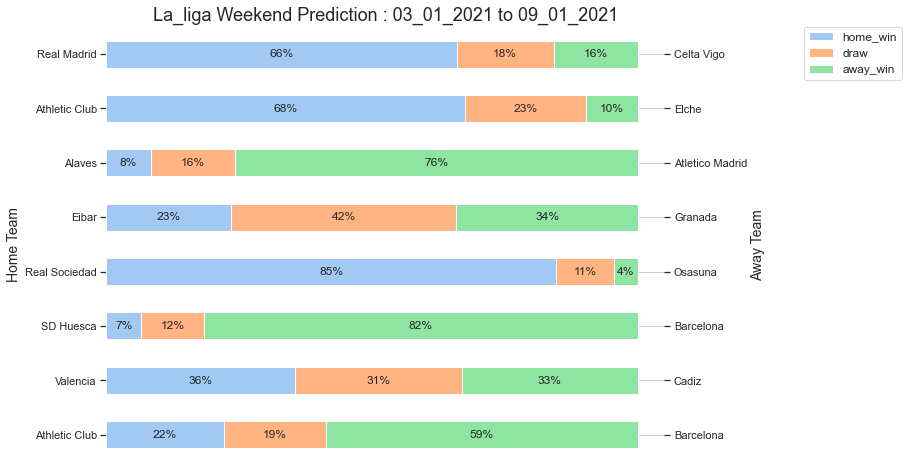

In [14]:
#Plotting the weekend prediction in Home Team - Home win% - Draw% - Away Team% - Away Team format

#https://stackoverflow.com/questions/34076177/matplotlib-horizontal-bar-chart-barh-is-upside-down
# the simplest solution for this problem is to reverse the pandas dataframe before plotting
predictions = predictions.iloc[::-1]

colors = sns.color_palette("pastel", n_colors=len(predictions['Home_Team']))
customPalette = sns.set_palette(sns.color_palette(colors))
#cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)

#ax = output2.plot(x="Home_Team", y=["home_win", "draw", "away_win"],kind = 'barh', stacked=True, colormap=cmap1,figsize=(10, 6))
ax = predictions.plot.barh(x="Home_Team", y=["home_win", "draw", "away_win"], stacked=True, colormap=customPalette,figsize=(10, 8))

ax2 = ax.twinx() #twinx() is used to have 2 different Y axes with same X axis

predictions.plot.barh(x="Away_Team", y=["home_win", "draw", "away_win"], ax=ax2,stacked=True, colormap=customPalette,figsize=(10, 8))


ax.set_title('%s Weekend Prediction : '%league_url  + today.strftime("%d_%m_%Y") + ' to ' + end_date.strftime("%d_%m_%Y"), fontsize = 18)
#ax.set_xlabel('Prediction')
ax.set_ylabel('Home Team', fontsize = 14)
ax2.set_ylabel('Away Team', fontsize = 14)
#ax.set_yticklabels(y_labels_home_win)

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize= BIGGER_SIZE)   # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize = BIGGER_SIZE)  # fontsize of the figure title 

#ax.get_legend().remove()
# move the legend
ax.legend(bbox_to_anchor=(1.25, 1), loc='upper left', borderaxespad=0.)

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

#https://stackoverflow.com/questions/37039685/hide-axis-values-but-keep-axis-tick-labels-in-matplotlib
rects = ax.patches  
    
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0%}'.format(width), 
            ha ='center', 
            va ='center')   

for p in ax2.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax2.text(x+width/2, 
            y+height/2, 
            '{:.0%}'.format(width), 
            ha ='center', 
            va ='center')   
ax2.get_legend().remove()
    
# Turn off tick labels
#ax.set_yticklabels([])
#ax.set_xticklabels([])
#plt.xticks([])
ax.set_xticks([])
ax2.set_xticks([])

plt.savefig('C:/Python Advanced/python-for-fantasy-football-master/python-for-fantasy-football-master/4 - APIs and JSON Data/Football Leagues Fixtures/%s/%s_Prediction '%(league_url,league_country) + today.strftime("%d_%m_%Y") + '.jpeg' ,bbox_inches='tight')


#### 